# Grid Resolution and Constraint Robustness

Systemic science demands that the present constraint survive modest changes to how we probe it. This notebook reruns the double-slit simulation across multiple spatial resolutions and checks that the detector correlations remain within tolerance. It ties to the overarching thesis by showing that fidelity is about preserving the whole constraint network (state + apparatus + detector) rather than chasing ever-finer fragments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from wavefunction_now.solver import SplitStepSimulator
from wavefunction_now.measurement import (
    chi_squared_gof,
    ks_goodness_of_fit,
    sample_measurements,
)

In [2]:
def run_double_slit(grid_points: int):
    sim = SplitStepSimulator(grid_points=grid_points, length=60.0)
    packet_left = sim.gaussian_wavepacket(sim.x, x0=-3.0, p0=7.0, sigma=0.6)
    packet_right = sim.gaussian_wavepacket(sim.x, x0=3.0, p0=7.0, sigma=0.6)
    psi0 = packet_left + packet_right
    psi0 /= np.sqrt(np.sum(np.abs(psi0) ** 2))
    psi_t = sim.evolve(psi0, potential=np.zeros_like(sim.x), dt=0.0025, steps=1200)
    bin_edges = np.linspace(sim.x.min(), sim.x.max(), 121)
    expected_prob = sim.bin_probabilities(psi_t, bin_edges)
    rng = np.random.default_rng(42)
    samples = sample_measurements(expected_prob, size=30000, rng=rng)
    counts = np.bincount(samples, minlength=expected_prob.size)
    chi2_stat, chi2_p = chi_squared_gof(expected_prob, counts)
    ks_stat, ks_p = ks_goodness_of_fit(expected_prob, samples)
    centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return centres, expected_prob, counts, chi2_stat, chi2_p, ks_stat, ks_p

In [3]:
results = []
for grid_points in (512, 1024, 2048):
    centres, expected_prob, counts, chi2_stat, chi2_p, ks_stat, ks_p = run_double_slit(grid_points)
    results.append({
        'grid': grid_points,
        'centres': centres,
        'expected': expected_prob,
        'counts': counts,
        'chi2_stat': chi2_stat,
        'chi2_p': chi2_p,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
    })

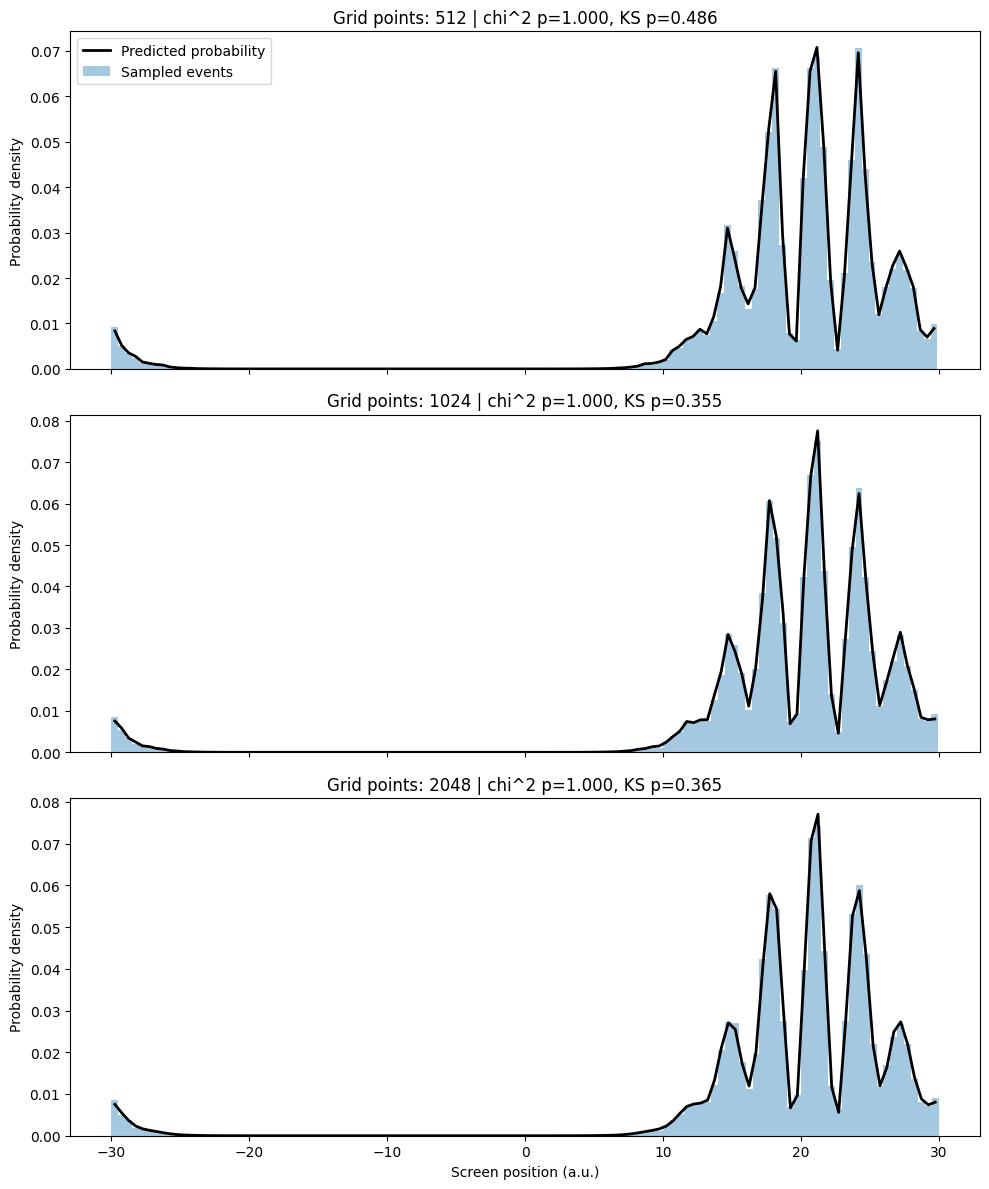

In [4]:
fig, axes = plt.subplots(len(results), 1, figsize=(10, 4 * len(results)), sharex=True)
if len(results) == 1:
    axes = [axes]
for ax, info in zip(axes, results):
    counts = info['counts'] / info['counts'].sum()
    ax.bar(info['centres'], counts, width=info['centres'][1]-info['centres'][0], alpha=0.4, label='Sampled events')
    ax.plot(info['centres'], info['expected'], color='black', linewidth=2, label='Predicted probability')
    ax.set_ylabel('Probability density')
    ax.set_title(f'Grid points: {info['grid']} | chi^2 p={info['chi2_p']:.3f}, KS p={info['ks_p']:.3f}')
axes[-1].set_xlabel('Screen position (a.u.)')
axes[0].legend()
plt.tight_layout()
plt.show()

The p-values summarised in each panel signal whether the correlation pattern is stable as the discretisation changes.